# 基盤データサイエンス演習 第4回

※本演習資料の二次配布・再配布はお断り致します。


　今回の演習の内容は以下の通りである。

　**DS4.0 | digitsデータセット**

　**DS4.1 | 主成分分析(principal component analysis: PCA)のdigitsデータセットへの適用**

　**DS4.2 | 主成分からの再構築**

　**DS4.3 | 主成分分析における分散共分散行列の固有値**


## DS4.0 | digitsデータセット

　今回は、手書き文字認識のデータ digits を用いる。digits は手書きの数字（0〜9）1文字の白黒画像と、対応する正しい数字からなるデータセットである。

　今回は scikit-learn 内に存在するデータをimportして使用するので、ファイルをアップロードする必要はない。

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt

d = datasets.load_digits()

まずは、どのような情報が含まれているデータなのか見てみよう。

`dir()`関数は、引数が持っているデータの一覧を取得することができる。

In [2]:
print(dir(d))

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']


それぞれ、`DESCR`はデータセットの説明（description）、`data`はベクトル形式の画像データ、`images`は画像形式の画像データ、`target`は画像に対応する0〜9の数字、target_namesはtargetの一覧(`[0, 1, ..., 9]`)である。

画像に相当する入力データ`d.data`は、各行が画像1枚に相当し、各列に画像の各ピクセルに対応する値を並べた行列である。今回の入力画像は8x8の解像度なので、列数は64である。

In [3]:
data = d.data
print(data.shape[1]) # show the number of columns of data
print(data) # show data

64
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


画像に相当するデータ`images`はarrayのリストのような形式で保存されている。

さて、画像と数字を対応させて表示してみよう。下のセルで、変数`image_index`で指定する番号の画像を表示できる。

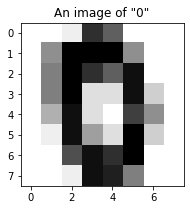

In [4]:
# display digits image
# change image_index and see each image with its label

images = d.images # images ("list of array"-like)
target = d.target # corresponding label numbers

image_index = 72
plt.figure(1, figsize=(3, 3))
plt.imshow(images[image_index], cmap=plt.cm.gray_r)
plt.title(f'An image of "{target[image_index]}"')
plt.show()

さて、これら0〜9の数字について、
* どの数字とどの数字は互いに似ていて、どの数字とどの数字は互いに似ていないだろうか。
* これらの数字が64次元の空間上にどのように分布しているかを簡単に知ることはできるだろうか。
* 8x8の画像のうち、データを特徴付けるのはどの部分だろうか。

これらのことを知ることができる手法の一つが主成分分析である。

---
##### 課題 DS4.1
　digitsデータセットについて、
1. 画像の総枚数
2. 件数が最も少ない数字（最も少ないものが複数ある場合、そのうちの最も値が小さい数字）

をそれぞれ調べよ。

（ヒント：1000件以上あるので目視で調べることは推奨しない。 `for` 文を用いて効率よく調べること）

---
## DS4.1 | 主成分分析 (principal component analysis: PCA) のdigitsデータセットへの適用

　PCAは可視化や次元削減などに用いられる教師なし学習手法の一つで、
データセットのばらつきの情報を保ってデータを低次元の空間に射影することができる。
まず、PCAを用いてデータを2次元に射影し、どの数字が空間上のどこに対応するか見てみよう。




In [5]:
# prepare PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 2 components will be used
pca.fit(data) # obtain principal component
images_map = pca.transform(data) # transform input data using PCA

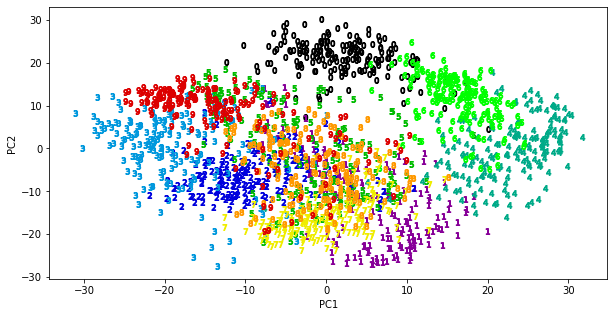

In [6]:
# scatter plot of PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
n_labels = 10

# set color palette for plot
color = [plt.cm.nipy_spectral(i/n_labels, 1) for i in range(n_labels)] 

# plot by each label
for i in range(n_labels):
  plt.scatter(images_map[target==i, 0], images_map[target==i, 1], 
              color=color[i], marker=f"${i}$")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

正しく実行されていれば、最初の二つの主成分の値に沿って各数字が出力されているはずである。

上の図からどのようなことが言えるだろうか。例えば、0や4は他の数字と比較的離れた分布をしていること、5, 8, 9が近い位置に分布していることなどが見て取れる。

この例では、64次元のデータを2次元に落とし込むことによって、データの分布をある程度可視化することができている。一方、数字間の重なりが大きく、2次元だけでは画像の情報を十分表現できていないこともわかる。

　また、PCAでは、各主成分（固有ベクトル）の値を見ることで、それぞれの主成分が主にどの列から構成されているか確認することができる。
固有ベクトルに対応する固有値の正の平方根を掛けて正規化したものが主成分負荷（principal component loading）である。

上位3つの主成分について、各主成分の内訳を見てみよう。

In [28]:
import pandas as pd

pca = PCA(n_components=3).fit(data) # PCA, use 3 components
components = pca.components_ # get components from PCA result

indexes = ["PC1", "PC2", "PC3"]
a = pd.DataFrame(components, index=indexes)
print(pd.DataFrame(components, index=indexes)) # print shaped result

               0         1         2         3         4         5         6   \
PC1 -3.310788e-18 -0.017309 -0.223429 -0.135913 -0.033032 -0.096634 -0.008329   
PC2  1.928679e-17 -0.010106 -0.049085 -0.009433 -0.053602 -0.117755 -0.062128   
PC3  3.892137e-17  0.018342  0.126475  0.132155 -0.134016 -0.264939 -0.116644   

           7         8         9   ...        54        55        56  \
PC1  0.002269 -0.000321 -0.119309  ... -0.063288  0.000962  0.000010   
PC2 -0.007936 -0.000163 -0.021017  ...  0.148776  0.000542 -0.000033   
PC3 -0.016842  0.000394  0.079437  ...  0.222787  0.021862 -0.000014   

           57        58        59        60        61        62        63  
PC1 -0.014079 -0.235675 -0.141226 -0.009160 -0.089418 -0.036598 -0.011468  
PC2 -0.010079 -0.070272  0.017111  0.194296  0.176697  0.019455 -0.006697  
PC3  0.017583  0.123158  0.098353  0.138485  0.232084  0.167027  0.034804  

[3 rows x 64 columns]


In [25]:
a

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
PC1,-9.726759e-18,-0.017309,-0.223429,-0.135913,-0.033032,-0.096634,-0.008329,0.002269,-0.000321,-0.119309,...,-0.063288,0.000962,0.000010,-0.014079,-0.235675,-0.141226,-0.009160,-0.089418,-0.036598,-0.011468
PC2,8.134708e-17,-0.010106,-0.049085,-0.009433,-0.053602,-0.117755,-0.062128,-0.007936,-0.000163,-0.021017,...,0.148776,0.000542,-0.000033,-0.010079,-0.070272,0.017111,0.194296,0.176697,0.019455,-0.006697
PC3,-2.066896e-18,0.018342,0.126476,0.132155,-0.134016,-0.264939,-0.116644,-0.016842,0.000394,0.079437,...,0.222787,0.021862,-0.000014,0.017583,0.123158,0.098353,0.138485,0.232084,0.167027,0.034804


　これでは全体の様子がよくわからないので、固有ベクトルを画像と同じ形式に直し、値の大小を色で表して可視化してみよう。

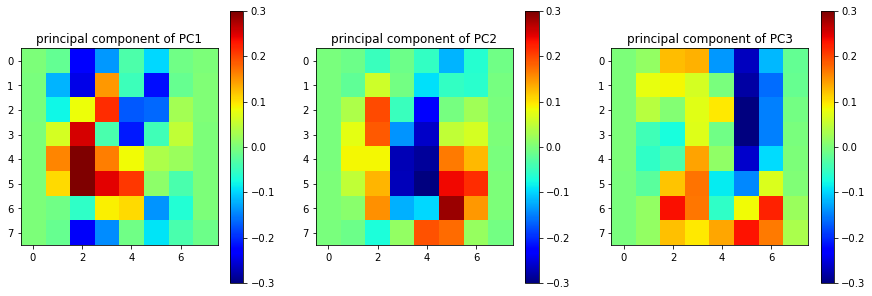

In [20]:
# show components on image

import numpy as np
fig = plt.figure(figsize=(15, 5))
for i in range(3): # for each component:
  
  plt.subplot(1, 3, i+1) # 3つに分割して図を描画する。i=0の時は一番左(i+1 = 1番目)。
  components_reshape = np.reshape(components[i], images[0].shape) # 1D vector -> 2D image-like format

  im = plt.imshow(components_reshape, cmap=plt.cm.jet)
  im.set_clim(-0.3,0.3) # set color range
  plt.title("principal component of PC"+str(i+1))

  plt.colorbar()

plt.show()

　ここで、固有ベクトルの各値の**符号の正負ではなく**、値の**絶対値**が大きい説明変数がデータの分散をより表現しているといえることに注意する必要がある。

　各主成分の寄与率 （explained variance ratio） は、元のデータの分散（$=$分散共分散行列の固有値の合計）のうちどれだけの割合をその主成分（に対応する固有値）が持っているかに相当する。実際に上位5つの主成分を用いて寄与率を見てみよう。

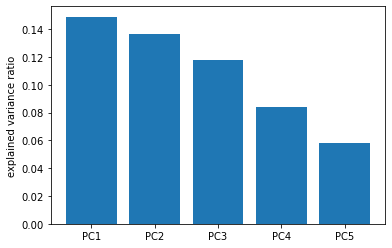

In [21]:
n_components = 5
indexes = [f"PC{i+1}" for i in range(n_components)]
fig = plt.figure(figsize=(6,4))

pca = PCA(n_components=n_components).fit(data) # PCA, use 5 components
explained_variance = pca.explained_variance_ratio_ # explained ratio
plt.bar(np.arange(n_components), explained_variance,
        tick_label=indexes)
plt.ylabel("explained variance ratio")
plt.show()

同様に、累積の寄与率は以下のようになる。

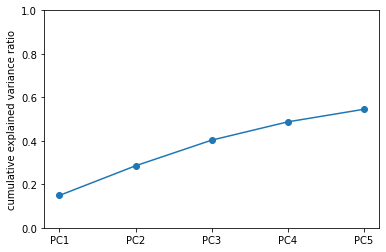

In [22]:
fig = plt.figure(figsize=(6,4))
cumulative_explained_variance = np.cumsum(explained_variance)

plt.plot(np.arange(n_components), cumulative_explained_variance, marker="o")
plt.xticks(range(n_components), indexes)
plt.ylim(0, 1)
plt.ylabel("cumulative explained variance ratio")
plt.show()

PCAでは固有値を大きい順に用いるので、寄与率は徐々に減少していく。

すべての主成分の寄与率の合計は1になるので、累積の寄与率をいくつの主成分を用いるかの基準として用いることができる。この場合、累積の寄与率の目安として0.7や0.8が用いられることがある。

---
##### 課題 DS4.2
　上のPCAの結果から、digitsデータセットの画像では、画像のどのような領域がデータの分散を表している（データによって大きく異なる）といえるか、考察せよ。

---
##### 課題 DS4.3
　PCAを行う際には、中心化と言って、まず各変数の平均が0になるように前処理するのが一般的である（※1）。例えば今回の画像のケースの場合、一番左上の画素 (pixel) の値について、データセット内での平均を0にするような操作である。

　scikit-learnの `PCA()` では中心化を自動でやってくれているのだが、その具体的な処理について知っておこう。下のコードは入力されたデータセット（データの集合）に対して中心化を行う関数 `centering(X)` である。これを用いて `d.data` を中心化せよ。
ただし、レポートには中心化後の最初の画像 `data[0, :]` の値のうち最も大きい値を、小数第三位を四捨五入して答えること。


In [26]:
def centering(X):
  return X - np.mean(X, axis=0)

In [35]:
data_center = centering(data)
data_center

array([[ 0.        , -0.30383973, -0.20478575, ..., -6.7640512 ,
        -2.06789093, -0.36449638],
       [ 0.        , -0.30383973, -5.20478575, ...,  3.2359488 ,
        -2.06789093, -0.36449638],
       [ 0.        , -0.30383973, -5.20478575, ...,  9.2359488 ,
         6.93210907, -0.36449638],
       ...,
       [ 0.        , -0.30383973, -4.20478575, ..., -0.7640512 ,
        -2.06789093, -0.36449638],
       [ 0.        , -0.30383973, -3.20478575, ...,  5.2359488 ,
        -2.06789093, -0.36449638],
       [ 0.        , -0.30383973,  4.79521425, ...,  5.2359488 ,
        -1.06789093, -0.36449638]])

In [36]:
data_center[0,:]

array([ 0.00000000e+00, -3.03839733e-01, -2.04785754e-01,  1.16416249e+00,
       -2.84808013e+00, -4.78185865e+00, -1.36227045e+00, -1.29660545e-01,
       -5.56483027e-03, -1.99387869e+00,  2.61769616e+00,  3.02058987e+00,
       -2.79354480e-01,  6.82415136e+00,  3.15358932e+00, -1.07957707e-01,
       -2.78241514e-03,  3.98441848e-01,  5.09682805e+00, -4.99276572e+00,
       -7.09794101e+00,  3.19365609e+00,  6.21146355e+00, -5.00834725e-02,
       -1.11296605e-03,  1.53032832e+00,  2.90873678e+00, -8.82136895e+00,
       -9.92710072e+00,  4.48525320e-01,  5.68224819e+00, -2.22593211e-03,
        0.00000000e+00,  2.66054535e+00,  3.32776850e-01, -9.07178631e+00,
       -1.03016138e+01,  2.55982193e-01,  5.09070673e+00,  0.00000000e+00,
       -8.90372844e-03,  2.41624930e+00,  4.11853088e+00, -7.22815804e+00,
       -6.67223150e+00,  3.76349471e+00,  3.54368392e+00, -2.72676683e-02,
       -7.23427935e-03,  1.29549249e+00,  6.49304396e+00, -4.53923205e+00,
        5.83750696e-01,  

In [52]:
print(f"{np.argsort(data_center[0,:])}")

[36 28 35 27 43 20 61 44 19  5 51 54  4 62  9 60  6 63  1 57 12 55  2  7
 15 23 47 40 48  8 16 31 24 56 32 39  0 37 34 17 58 29 52 59  3 49 25 41
 10 33 26 11 14 21 53 46 45 42 38 18 30 22 50 13]


In [54]:
print(f"{np.sort(data_center[0,:])}")

[-1.03016138e+01 -9.92710072e+00 -9.07178631e+00 -8.82136895e+00
 -7.22815804e+00 -7.09794101e+00 -6.76405120e+00 -6.67223150e+00
 -4.99276572e+00 -4.78185865e+00 -4.53923205e+00 -3.72509738e+00
 -2.84808013e+00 -2.06789093e+00 -1.99387869e+00 -1.80912632e+00
 -1.36227045e+00 -3.64496383e-01 -3.03839733e-01 -2.79354480e-01
 -2.79354480e-01 -2.06455203e-01 -2.04785754e-01 -1.29660545e-01
 -1.07957707e-01 -5.00834725e-02 -2.72676683e-02 -8.90372844e-03
 -7.23427935e-03 -5.56483027e-03 -2.78241514e-03 -2.22593211e-03
 -1.11296605e-03 -5.56483027e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.55982193e-01  3.32776850e-01  3.98441848e-01
  4.42404007e-01  4.48525320e-01  5.83750696e-01  9.10962716e-01
  1.16416249e+00  1.29549249e+00  1.53032832e+00  2.41624930e+00
  2.61769616e+00  2.66054535e+00  2.90873678e+00  3.02058987e+00
  3.15358932e+00  3.19365609e+00  3.24151363e+00  3.54368392e+00
  3.76349471e+00  4.11853088e+00  5.09070673e+00  5.09682805e+00
  5.68224819e+00  6.21146

In [53]:
print(f"{np.argmax(data_center[0,:])}")

13


In [55]:
max_value=  np.max(data_center[0,:])
print(f"{np.max(data_center[0,:]):.3f}")

6.824


----

## DS4.2 | 主成分からの再構築


　PCAは次元削減にも利用される手法であった。PCAを行った後、いくつかの主成分だけを残すことによって、元の行列をより小さい次元で近似することができる。このとき、元のデータの情報はどの程度残っているのだろうか。これはPCAで次元削減を行い、その結果に逆変換を行ってデータを元の形式に戻すことによって視覚的に確認することができる。

　下のセル群を`n_components`を変えながら何度か実行することで、使用した次元数と復元後の関係を見ることができる。復元の精度が良いほど、より多くの情報が残っているといえる。

　下のセル群のうち、上のセルが変換・逆変換を行う関数で、下の2セルがプロットする部分である。`n_components`で削減する次元数を、`image_index`で表示する画像を指定することができる。元の画像が64次元であるため、`n_components`には1以上64以下の値を指定すること。

In [27]:
def project_reconstruct(data, n_components):
  pca = PCA(n_components=n_components)
  pca.fit(data)
  data_map = pca.transform(data) # projection
  data_reconstructed = pca.inverse_transform(data_map) # reconstruction
  sum_explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

  return data_reconstructed, sum_explained_variance_ratio

In [72]:
data = datasets.load_digits().data
# project and reconstruct of data by PCA
n_components = 3 # the number of components to be used

data_reconstructed, sum_explained_variance_ratio = \
  project_reconstruct(data, n_components)
print(f"Cumulative explained variance ratio: {sum_explained_variance_ratio:.4f}")

Cumulative explained variance ratio: 0.4030


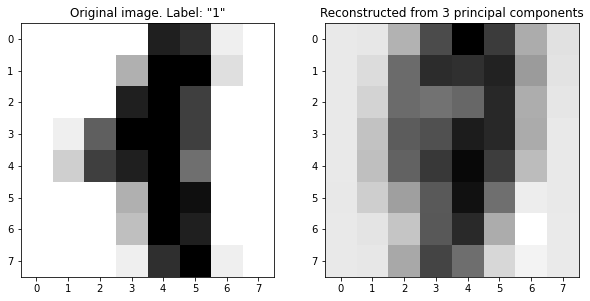

In [63]:
# show above result
image_index = 11 # the index of image to be shown
image_reconstructed = np.reshape(data_reconstructed[image_index],
                                 images[0].shape)

fig = plt.figure(figsize=(10, 5))

# show original image
plt.subplot(1, 2, 1)
plt.imshow(images[image_index], cmap=plt.cm.gray_r)
plt.title(f'Original image. Label: "{target[image_index]}"')

# show reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap=plt.cm.gray_r)
plt.title(f"Reconstructed from {n_components} principal components")

plt.show()

実行した結果から、残した次元数が多いほど復元の精度が良い、つまり情報が多く残っていることが見て取れるはずである。

このように、元々のデータが視覚的に捉えられる場合には、実際に復元してみることでも使用するべき主成分の数を判断することができる。

---
## DS4.3 | 主成分分析における分散共分散行列の固有値

　講義ですでに証明したように、PCAで用いる主成分およびその寄与は元のデータの分散共分散行列（単に共分散行列とも言う）の固有ベクトルおよび固有値から求めることができる。`PCA.fit`では「分散共分散行列の固有ベクトルおよび固有値を計算し、大きい順に並べ替えて答える」ことに相当する処理（※2）を行なっている。

　ここではこの計算を**scikit-learnを通さず**行い、scikit-learnのPCAと同様の結果が得られることを確認する。

In [64]:
# 課題 DS4.3 と同一の関数
def centering(X):
  return X - np.mean(X, axis=0)

In [65]:
np.cov(data_centered, rowvar=False)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.8229975 ,  2.40099498, ..., -0.1598953 ,
         0.09851423, -0.07406182],
       [ 0.        ,  2.40099498, 22.60837352, ..., -1.15544033,
         1.41203571,  0.72988047],
       ...,
       [ 0.        , -0.1598953 , -1.15544033, ..., 34.81734839,
        15.64854441,  2.87558266],
       [ 0.        ,  0.09851423,  1.41203571, ..., 15.64854441,
        16.73258202,  4.72078588],
       [ 0.        , -0.07406182,  0.72988047, ...,  2.87558266,
         4.72078588,  3.46005282]])

In [66]:
np.cov(data_centered, rowvar=True)

array([[ 15.66680678, -11.13685519,  -4.92908276, ...,  -3.97204457,
          4.516192  ,  -1.68631483],
       [-11.13685519,  18.27153641,   5.68243385, ...,   5.32349981,
         -2.18975172,  -3.34860775],
       [ -4.92908276,   5.68243385,  20.36292453, ...,   6.17016113,
         -3.00132452,   1.97870834],
       ...,
       [ -3.97204457,   5.32349981,   6.17016113, ...,  15.08751678,
         -0.54329427,   7.80975446],
       [  4.516192  ,  -2.18975172,  -3.00132452, ...,  -0.54329427,
         14.55506134,   2.07477674],
       [ -1.68631483,  -3.34860775,   1.97870834, ...,   7.80975446,
          2.07477674,  13.68973023]])

In [67]:
# calculate covariance matrix
data_centered = centering(data)
cov_matrix = np.cov(data_centered, rowvar=False)

In [68]:
# calculate eigenvalue/eigenvector of covariance matrix
from numpy.linalg import eig
eig_val, eig_vec = eig(cov_matrix)

# sort by eigenvector (descending)
n_components = 3
eig_index = np.argsort(eig_val)      # argsortは要素の昇順になるように添え字を並べる
eig_index = eig_index[::-1]          # 降順を得るために[::-1]で順番を逆にする
eig_index = eig_index[:n_components] # 降順でn_components個だけ添え字を取得する
eig_val = eig_val[eig_index]         # 固有値を大きい順に取得
eig_vec = eig_vec.T[eig_index]       # 対応する固有ベクトルを取得

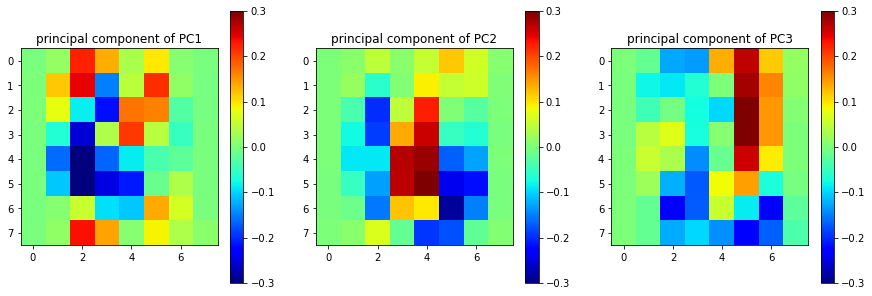

In [69]:
# show

fig = plt.figure(figsize=(15, 5))
for i in range(n_components):
  
  plt.subplot(1, n_components, i+1)
  eig_vec_reshape = np.reshape(eig_vec[i], images[0].shape)

  im = plt.imshow(eig_vec_reshape, cmap=plt.cm.jet)
  im.set_clim(-0.3,0.3)
  plt.title("principal component of PC"+str(i+1))
  plt.colorbar()
    
plt.show()

　主成分（固有ベクトル）を見ることにより、scikit-learnのPCAと同様の結果になっていることが確認できる。
なお、主成分の符号が反転している場合があるが、ベクトルの向きが反対になっているだけで表している意味は同じである。

---
##### 課題 DS4.4
　固有ベクトルが等しいことを確認したので、固有値も等しくなっていることを確認しよう。
PCA関数で計算した固有値と直接計算した固有値が一致することを確認し、最も大きい固有値を小数点以下を四捨五入し整数で答えよ。
ただし、PCA関数で計算した結果の固有値は`pca.explained_variance_`で取得することができる。


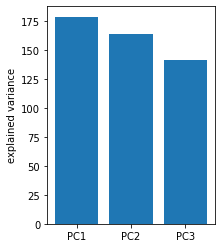

In [80]:
n_components = 3
indexes = [f"PC{i+1}" for i in range(n_components)]
fig = plt.figure(figsize=(3,4))

pca = PCA(n_components=n_components).fit(data) # PCA, use 3 components
explained_variance = pca.explained_variance_ # explained ratio
plt.bar(np.arange(n_components), explained_variance,
        tick_label=indexes)
plt.ylabel("explained variance")
plt.show()

In [74]:
explained_variance

array([179.0069301 , 163.71774688, 141.78843909])

In [79]:
print(f"{np.max(explained_variance):.0f}")

179


----
# レポート提出について


## レポートの提出方法

　レポートは**答案テンプレートを用い**、**1つのファイル（.doc, .docx, .pdf）**にまとめ、**学籍番号と氏名を確認の上**、**次回 基盤データサイエンス演習 の開始時刻までに東工大ポータルのOCW-iから提出**すること。
ファイルのアップロード後、OCW-iで「提出済」というアイコンが表示されていることを必ず確認すること。それ以外の場合は未提出扱いとなるので十分注意すること。
また、締め切りを過ぎるとファイルの提出ができないため、時間に余裕を持って提出を行うこと。


### 答案テンプレート
```
学籍番号:

名前:

課題 DS4.1

画像の総枚数：
件数が最も少ない数字：

課題 DS4.2

(課題 DS4.2の答案をここに記入すること)

課題 DS4.3

中心化後の最初の画像の値のうち最も大きい値: __________

課題 DS4.4

最も大きい固有値: __________

```


-----

# 補足資料

### ※1 PCAの中心化について

　PCAでは中心化が行われるが、正規化（平均を 0、分散を 1 にする）ではないのか？と思われる人もいるだろう。これは良い発想で、分散を 1 にする方が良い場合と良くない場合がある。[scikit-learnのPCAのドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)によれば、（データの大きさを揃えることで）変換されたデータの分散の大きさの情報が失われるが、機械学習の入力として用いる場合は予測精度が向上する可能性がある。

※2 実際のPCA.fitで行われている処理

　実際には、`PCA.fit()`では分散共分散行列の固有値・固有ベクトルを求める処理の代わりに、元の行列の特異値分解の結果から分散共分散行列の固有値・固有ベクトルを求めている。 詳細は[実装](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/_pca.py)などを参照。